In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from collections import OrderedDict
%matplotlib inline
from astropy.cosmology import FlatLambdaCDM

cosmo = FlatLambdaCDM(H0=70.4, Om0=0.2726, Ob0=0.0456)

#local imports
from detection_rate_main import detection_rate_main, z_at
from utils.mergerrate import MergerRate
from utils.mbhbinaries import  mass_ratio_func
from utils.evolveFDFA import EvolveFDFA
from utils.basicmergers import NoDelay, ConstantTime, NoDelayOrigExtract

import sys
sys.path.append('utils/evolve_lzk/zcode/')
from utils.evolve_lzk.evolveLZK import EvolveLZK

from gwsnrcalc.utils.waveforms import PhenomDWaveforms
from gwsnrcalc.gw_snr_calculator import snr
from gwsnrcalc.utils.readnoisecurves import read_noise_curve
import scipy.constants as ct
from scipy import stats
Msun=1.989e30
import pdb
import os

## Declare Resample Parameters

In [7]:
num_catalogs = 200
num_repeats = 50
t_obs = 4.0 #years
duration = 100.0 #years

#input file
fp = 'simulation_input_data_lzk.txt'

##################
###### KDE #######
##################

# what key for the input data for m1, m2. It is not
# needed for z because we calculate z_coalescence. 
kde_key_guide = OrderedDict()
kde_key_guide['m1'] = 'mass_new_prev_in'
kde_key_guide['m2'] = 'mass_new_prev_out'
#kde_key_guide['z'] = 'redshift'


###########################
###### merger rate  #######
###########################

# kwargs related to merger rate calculation
merger_rate_kwargs = {'Vc':106.5**3, 'dz':0.001, 'zmax':10.0}

############################################
###### Parrallel Calculation of SNRs #######
############################################
parallel_kwargs = {'num_processors':None, 'num_splits':1000, 'verbose':50}


##########################
###### SNR Options #######
##########################
snr_kwargs = {'add_wd_noise':'True', 'num_points':2048, 'sensitivity_curves': ['PL', 'CLLF'], 'prefactor':np.sqrt(2*16./5.), 'spin': 0.8, 'signal_type':['all', 'ins', 'mrg', 'rd']}

## Run the Resampler

In [7]:
data = np.genfromtxt('simulation_input_data_lzk.txt', names=True)

evolve_dict = {'fname': 'simulation_input_data_lzk.txt'}
evolution_classes = [[EvolveLZK, 'K17'],
                     [EvolveFDFA, 'DA17'],
                     [NoDelay, 'ND'],
                     [NoDelayOrigExtract, 'ND-6']]

scs = ['PL', 'CLLF']
dz = 0.001
evolve_out = {}
for evolve_class, label in evolution_classes:
    if label + '_catalogs_' + 'PL' + '.npy' in os.listdir():
        if label not in evolve_out:
            evolve_out[label] = {}
        if 'cats_det' not in evolve_out[label]:
            evolve_out[label]['cats_det'] = {}
        for sc in scs:
            evolve_out[label]['cats_det'][sc] = np.load(label + '_catalogs_' + sc + '.npy')
        print(label, 'catalogs loaded')
        continue
    cats_det = detection_rate_main(num_catalogs, t_obs, duration, fp,
                                    evolve_dict, kde_key_guide, evolve_class,
                                    merger_rate_kwargs, snr_kwargs,
                                    only_detectable=True, snr_threshold=8.0, num_repeats=num_repeats)
    for sc in cats_det:
        np.save(label + '_catalogs_' + sc, cats_det[sc])
    evolve_out[label] = {'cats_det':cats_det}
    print(label, 'done')
evolve_out['data'] = {'m1': data['mass_new_prev_in'], 'm2': data['mass_new_prev_out'],
                              'mt': data['mass_new_prev_in'] + data['mass_new_prev_out'],
                              'mr': mass_ratio_func(data['mass_new_prev_in'], data['mass_new_prev_out'])}

K17 catalogs loaded
DA17 catalogs loaded
ND catalogs loaded
ND-6 catalogs loaded


In [18]:
data = np.genfromtxt('simulation_input_data_lzk.txt', names=True)

evolve_dict = {'fname': 'simulation_input_data_lzk.txt'}
evolution_classes = [[EvolveLZK, 'K17'],
                     [EvolveFDFA, 'DA17'],
                     [NoDelay, 'ND'],
                     [NoDelayOrigExtract, 'ND-old']]

dz = 0.25
evolve_out_base = {}
for evolve_class, label in evolution_classes:
    evolve = evolve_class(**evolve_dict)
    evolve.evolve()
    keep = (evolve.coalescence_time<cosmo.age(0.0).value*1e9) & (mass_ratio_func(data['mass_new_prev_in'], data['mass_new_prev_out'])>1e-4)
    z_coal = z_at(evolve.coalescence_time[keep])
    
    merger_rate_info = {}
    mr = MergerRate(z_coal, 106.5**3,dz=dz)
    print(len(z_coal))
    zs, integrand, rate = mr.merger_rate(return_for_plot=True)
    merger_rate_info['non_det'] = {'zs': zs, 'integrand': integrand, 'rate': rate}
    
    snr_vals = (snr(evolve.m1[keep], evolve.m2[keep], np.full(len(evolve.m1[keep],), 0.8),
                    np.full(len(evolve.m1[keep],), 0.8), z_coal, 1.0, 0.0,
                    sensitivity_curves=['PL', 'CLLF'], add_wd_noise='True', signal_type=['all', 'ins', 'mrg', 'rd']))
    #pdb.set_trace()
    
    for key in ['CLLF', 'PL']:
        for key2 in ['all', 'ins', 'mrg_rd']:
            if key2 == 'mrg_rd':
                mr_det = MergerRate(z_coal[snr_vals[key + '_wd_mrg'] + snr_vals[key + '_wd_rd']>8.0], 106.5**3,dz=dz)
            else:
                mr_det = MergerRate(z_coal[snr_vals[key + '_wd_' + key2]>8.0], 106.5**3,dz=dz)
            if key2 == 'all':
                detectable_keep = np.where(snr_vals[key + '_wd_' + key2]>8.0)[0]
            zs_det, integrand_det, rate_det = mr_det.merger_rate(return_for_plot=True)
            uncertainty = mr_det.merger_rate_uncertainty()
            merger_rate_info[key + '_' + key2] = {'zs': zs_det, 'integrand': integrand_det, 'rate': rate_det, 'detect_keep': detectable_keep, 'uncertainty': uncertainty}
            
        # spectroscopy
        q = mass_ratio_func(evolve.m1[keep], evolve.m2[keep])
        rho_23 = 17.687 + 15.4597/(q-1) - 1.65242/q
        rho_24 = 37.9181 + 83.5778/q + 44.1125/q**2 + 50.1316/q**3
        spec_keep = ((snr_vals[key + '_wd_rd']>rho_23) | (snr_vals[key + '_wd_rd']>rho_24)) & (snr_vals[key + '_wd_rd']>8.0)
        mr_det = MergerRate(z_coal[spec_keep], 106.5**3,dz=dz)
        zs_det, integrand_det, rate_det = mr_det.merger_rate(return_for_plot=True)
        uncertainty = mr_det.merger_rate_uncertainty()
        merger_rate_info[key + '_spec'] = {'zs': zs_det, 'integrand': integrand_det, 'rate': rate_det, 'uncertainty': uncertainty}

    print(label, rate, 'sigma:', uncertainty)
    print(label, 'snr')
    
    evolve_out_base['data'] = {'m1': data['mass_new_prev_in'], 'm2': data['mass_new_prev_out'],
                          'mt': data['mass_new_prev_in'] + data['mass_new_prev_out'],
                          'mr': mass_ratio_func(data['mass_new_prev_in'], data['mass_new_prev_out'])}
    evolve_out_base[label] = {'merger_rate_info': merger_rate_info,
                         'coalesced': keep, 'detectable': detectable_keep, 'timescale': evolve.t_delay}
    print(label, 'done')

BAD  gas  7/17535 = 0.0003992015968063872
	resetting to 10.0%ile value: 3.1e-31
_dens_prof_norms.shape =  (3, 17535)


/Users/michaelkatz/Research/Illustris_LISA_paper/code/utils/evolve_lzk/evolveLZK.py:209: UserWarning: Using fixed velocity dispersion!
  warnings.warn("Using fixed velocity dispersion!")


vdisp[pc] = (2.92e+06, 1.15e+07, 1.83e+07, 2.84e+07, 7.07e+07), for (0%, 16%, 50%, 84%, 100%)
DT T[9e-03 pc]/YR = (3.60e+01, 1.67e+06, 1.59e+07, nan, inf), for (0%, 16%, 50%, 84%, 100%)
DF T[1e+03 pc]/YR = (1.37e-05, 1.94e+03, 5.15e+05, 3.26e+08, 8.64e+14), for (0%, 16%, 50%, 84%, 100%)


/Users/michaelkatz/Research/Illustris_LISA_paper/code/utils/evolve_lzk/stellar_scattering.py:183: UserWarning: Using SHM06 Scaling-Relations for LC Scattering
  warnings.warn("Using SHM06 Scaling-Relations for LC Scattering")


(17535, 1) (17535, 1) (1, 200)
(1.47e+05, 2.61e+06, 2.22e+07, 5.01e+08, 2.05e+10), for (0%, 16%, 50%, 84%, 100%)
(1.42e+05, 2.91e+05, 1.21e+06, 6.59e+06, 4.09e+09), for (0%, 16%, 50%, 84%, 100%)
GW T[9e-03 pc]/YR = (2.02e+01, 2.91e+07, 1.86e+10, 2.64e+12, 2.94e+15), for (0%, 16%, 50%, 84%, 100%)

All done after 0:00:02.518855
11526
K17 0.6093517076014959 sigma: 0.1312472750423829
K17 snr
K17 done
14724
DA17 0.8816400996236394 sigma: 0.20150265820990113
DA17 snr
DA17 done
16999
ND 1.0749146893297599 sigma: 0.21308650667343548
ND snr
ND done
9611
ND-old 0.624554042522871 sigma: 0.12588916487978458
ND-old snr
ND-old done


In [21]:
def merger_integrand(evolve_out, labels, ax, key, label_fontsize=18, tick_fontsize=14, legend=True, legend_label='label'):
    snr_bins = np.linspace(np.log10(8.0), 5.0, 20)
    for label in labels:
        print(key)
        mri = evolve_out[label]['merger_rate_info'][key]
        z, dN_dzdt = mri['zs'], -mri['integrand']
        if legend_label == 'label':
            lab = label
        else:
            lab = key
        if label == 'ND-old':
            lab = 'ND-6'
        ax.plot(z, dN_dzdt, label=lab)
        merger_rate = np.trapz(dN_dzdt, x=z)
        print(label, key, 'Rate:', merger_rate)

    xticks = [0,2,4,6,8]
    ax.set_xlim(np.log10(8.0), max(xticks))
    ax.set_xticks(xticks)
    ax.set_xticklabels(['%i'%i for i in xticks], fontsize=tick_fontsize)
    
    yticks = [0.0,0.1,0.2,0.3,0.4,0.5]
    ax.set_ylim(min(yticks), max(yticks))
    ax.set_yticks(yticks)
    ax.set_yticklabels(['%.2g'%i for i in yticks], fontsize=tick_fontsize)

    ax.set_xlabel('Redshift',fontsize=label_fontsize)
    ylabel = r'$\frac{dN}{dzdt_{obs}}$'
    ax.set_ylabel(ylabel, rotation='horizontal', labelpad=40, fontsize=label_fontsize)
    if legend:
        ax.legend(loc='best', prop={'size':15})
    
    return ax

In [ ]:
def snr_hist(evolve_out, labels, ax, label_fontsize=18, tick_fontsize=14, legend=True, sc='PL'):
    snr_bins = np.linspace(np.log10(8.0), 5.0, 20)
    for label in labels:
        snr_label = evolve_out[label]['cats_det'][sc]['snr']
        ax.hist(np.log10(snr_label), bins=snr_bins, label=label, histtype='step', lw=1.5, log=True, density=True)

    xticks = [1,2,3,4,5]
    ax.set_xlim(np.log10(8.0), max(xticks))
    ax.set_xticks(xticks)
    ax.set_xticklabels(['%i'%i for i in xticks], fontsize=tick_fontsize)
    
    #yticks = [0,1,2,3,4,5]
    #ax.set_ylim(min(xticks), max(xticks))
    #ax.set_yticks(xticks)
    #ax.set_yticklabels(['%i'%i for i in xticks], fontsize=14)
   

    ax.set_xlabel('Signal-to-Noise Ratio',fontsize=label_fontsize)
    ax.set_ylabel('Density', labelpad=20, fontsize=label_fontsize)
    if legend:
        ax.legend(loc='best')
    return ax

In [ ]:
def detection_hist(evolve_out, labels, ax, label_fontsize=18, tick_fontsize=14, legend=True, sc='PL'):
    detection_bins = np.linspace(0.0, 5.0, 20)
    for label in labels:
        uni_vals, uni_counts = np.unique(evolve_out[label]['cats_det'][sc]['cat'], return_counts=True)
        per_year_counts = uni_counts/t_obs
        print(label, 'mean detect counts', np.mean(per_year_counts))
        ax.hist(per_year_counts, bins=detection_bins, label=label, histtype='step', lw=1.5, log=True, density=True)

    xticks = [0,1,2,3,4,5]
    ax.set_xlim(0.0, max(xticks))
    ax.set_xticks(xticks)
    ax.set_xticklabels(['%i'%i for i in xticks], fontsize=tick_fontsize)
    
    #yticks = [0,1,2,3,4,5]
    #ax.set_ylim(min(xticks), max(xticks))
    #ax.set_yticks(xticks)
    #ax.set_yticklabels(['%i'%i for i in xticks], fontsize=14)
   

    ax.set_xlabel('Detection Count',fontsize=label_fontsize)
    ax.set_ylabel('Density', labelpad=20, fontsize=label_fontsize)
    if legend:
        ax.legend(loc='best')
    return ax

non_det
DA17 non_det Rate: 0.8816400996236394
non_det
K17 non_det Rate: 0.609351707601496
non_det
ND-old non_det Rate: 0.6245540425228711
non_det
ND non_det Rate: 1.0749146893297599
PL_all
DA17 PL_all Rate: 0.7572572027661411
PL_all
K17 PL_all Rate: 0.49182756660856575
PL_all
ND-old PL_all Rate: 0.4842916567795062
PL_all
ND PL_all Rate: 0.8264894710557547


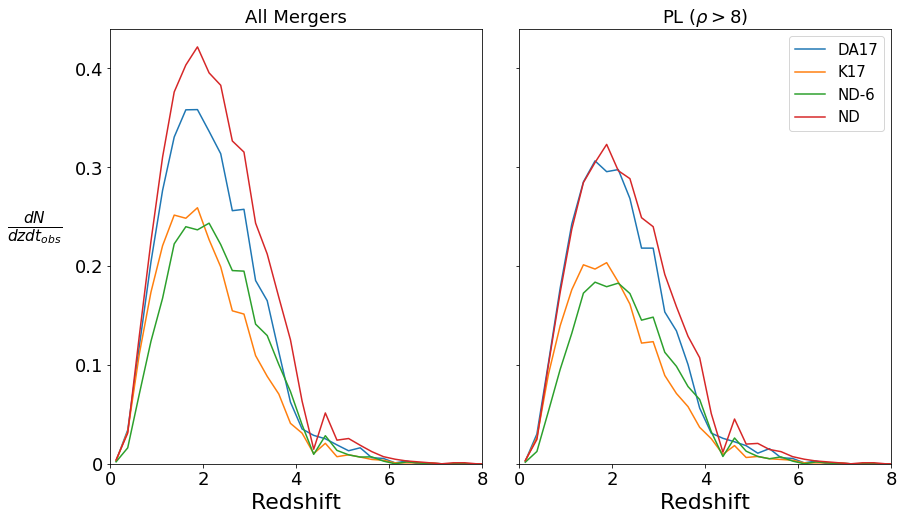

In [22]:
labels = ['DA17','K17', 'ND-old', 'ND']
fig, ax = plt.subplots(1,2, sharey=True)
plt.subplots_adjust(wspace=0.1)
fig.set_size_inches(14,8)
ax = ax.ravel()

for i, (key, title) in enumerate([['non_det', 'All Mergers'], ['PL_all', r'PL ($\rho>8$)']]):
    if i == 1:
        legend = True
    else:
        legend = False
    ax[i] = merger_integrand(evolve_out_base, labels, ax[i], key, label_fontsize=22, tick_fontsize=18, legend=legend)
    ax[i].set_ylim(0.0, 0.44)
    if i > 0:
        ax[i].set_ylabel('')
    ax[i].set_title(title, fontsize=18)
fig.savefig('figures/detection_results.pdf', dpi=200)

In [7]:
for label in ['ND', 'ND-old', 'DA17', 'K17']:
    for sig in ['all', 'ins', 'mrg_rd', 'spec']:
        for sc in ['PL', 'CLLF']:
            print(label, sc, sig, '%.2g'%evolve_out_base[label]['merger_rate_info'][sc + '_' + sig]['rate'], '%.2g'%evolve_out_base[label]['merger_rate_info'][sc + '_' + sig]['uncertainty'])
    print('\n')

ND PL all 0.75 0.0097
ND CLLF all 0.89 0.011
ND PL ins 0.45 0.007
ND CLLF ins 0.75 0.0097
ND PL mrg_rd 0.77 0.0098
ND CLLF mrg_rd 0.89 0.011
ND PL spec 0.74 0.0095
ND CLLF spec 0.88 0.011


ND-old PL all 0.44 0.0071
ND-old CLLF all 0.51 0.0077
ND-old PL ins 0.23 0.0047
ND-old CLLF ins 0.43 0.0069
ND-old PL mrg_rd 0.45 0.0072
ND-old CLLF mrg_rd 0.52 0.0077
ND-old PL spec 0.43 0.0069
ND-old CLLF spec 0.51 0.0077


DA17 PL all 0.69 0.0087
DA17 CLLF all 0.77 0.0094
DA17 PL ins 0.42 0.0064
DA17 CLLF ins 0.68 0.0087
DA17 PL mrg_rd 0.7 0.0089
DA17 CLLF mrg_rd 0.77 0.0094
DA17 PL spec 0.67 0.0086
DA17 CLLF spec 0.77 0.0093


K17 PL all 0.44 0.0066
K17 CLLF all 0.5 0.0072
K17 PL ins 0.28 0.005
K17 CLLF ins 0.44 0.0066
K17 PL mrg_rd 0.45 0.0067
K17 CLLF mrg_rd 0.51 0.0072
K17 PL spec 0.43 0.0065
K17 CLLF spec 0.5 0.0071




/Users/michaelkatz/anaconda3/envs/ill_env/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in multiply


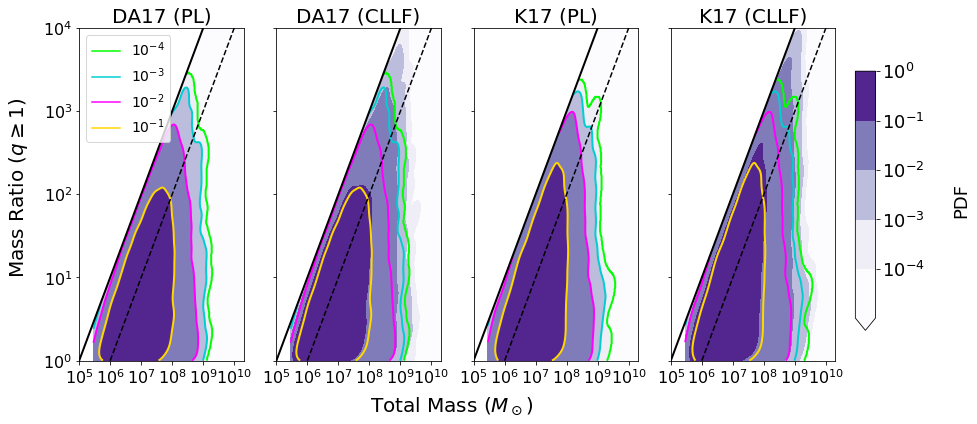

In [11]:
labels = ['DA17 (PL)', 'DA17 (CLLF)', 'K17 (PL)', 'K17 (CLLF)']
#labels = ['DA17 (PL)', 'K17 (PL)', 'DA17 (CLLF)']
fig, ax = plt.subplots(1, len(labels), sharex=True, sharey=True)
try:
    ax = ax.ravel()
except AttributeError:
    ax = [ax]
    

plt.subplots_adjust(left=0.08, right=0.83, top=0.9, bottom=0.13)
fig.set_size_inches(14,6)
cax = fig.add_axes([0.85, 0.2, 0.02, 0.6])
tickfontsize=16
labelfontsize=18
norm = matplotlib.colors.Normalize(vmin=-4.,vmax=0.)

fig.text(0.02, 0.53, r'Mass Ratio $(q\geq 1)$', rotation='vertical', va='center', ha='center', fontsize=20)
fig.text(0.45, 0.025, r'Total Mass ($M_\odot$)', va='center', ha='center', fontsize=20)

dl = 1.0
start_val = -4.0
end_val = 0.0
levels = list(np.arange(start_val, end_val+dl, dl))
levels = [-1000] + levels
    
line1_xvals = np.linspace(6.0, 11.0)
line1_yvals = line1_xvals - 6

line2_xvals = np.linspace(5.0, 10.0)
line2_yvals = line2_xvals - 5
num = 300
xx, yy = np.meshgrid(np.linspace(np.log10(evolve_out['data']['mt'].min()), np.log10(evolve_out['data']['mt'].max()), num),
                     np.linspace((-1*np.log10(evolve_out['data']['mr']).max()), (-1*np.log10(evolve_out['data']['mr']).min()), num))

cmap = matplotlib.cm.Purples
cmap.set_bad('white', alpha=1.0)
limiter = -4
for i, label in enumerate(labels):
    sc = 'CLLF' if label[-6:] == '(CLLF)' else 'PL'
    #sc = 'CLLF' if label == 'DA17 (CLLF)' else 'PL'
    
    #evolve_label = 'ND' if label != 'ND-6 (PL)' else 'ND-6'
    evolve_label = label.split(' ')[0]
    #evolve_label = 'DA17' if label != 'K17 (PL)' else 'K17'
    
    cats_all = evolve_out[evolve_label]['cats_det'][sc]
    data = np.array([np.log10(cats_all['m1'] + cats_all['m2']), -np.log10(mass_ratio_func(cats_all['m1'],cats_all['m2']))])
    kde = stats.gaussian_kde(data)

    density = kde(np.c_[xx.flat, yy.flat].T).reshape(xx.shape)    
    density = np.log10(density)*(density>10**limiter)+limiter*(density<10**limiter)

    ax[i].plot(line1_xvals, line1_yvals, color='k', ls='dashed')
    ax[i].plot(line2_xvals, line2_yvals, color='k', lw=2)
    mask_val = 6 if label == 'ND-6 (PL)' else 5
    density = np.ma.masked_where((xx - mask_val < yy), density)

    cset = ax[i].contourf(xx, yy, density, levels=levels, norm=norm, cmap=cmap, extend='min')
    #if label == 'ND (PL)':
    if label == 'DA17 (PL)' or label == 'K17 (PL)':
        store_density = density.copy()
    ax[i].contour(xx, yy, store_density, levels=[-4, -3., -2, -1, 0], colors=['lime', 'darkturquoise', 'magenta', 'gold'], linewidths=2)
    if i == 0:
        cbar = fig.colorbar(cset, cax=cax)
        ticks = [-4,-3,-2,-1,0]
        cbar.set_ticks(ticks)
        cbar.set_ticklabels([r'$10^{%i}$'%i for i in ticks])
        cbar.ax.tick_params(labelsize=labelfontsize)
        cbar.set_label('PDF', fontsize=labelfontsize, labelpad=27)

    yticks = [0,1,2,3,4]
    ax[i].set_yticks(yticks)
    ax[i].set_yticklabels([r'$10^{%i}$'%i for i in yticks], fontsize=tickfontsize)
    ax[i].set_ylim(0,4)

    xticks = [5,6,7,8,9,10]
    ax[i].set_xticks(xticks)
    ax[i].set_xticklabels([r'$10^{%i}$'%i for i in xticks], fontsize=tickfontsize)
    ax[i].set_xlim(5, 10.3)
    ax[i].set_title(label, fontsize=20)
    if i == 0:
        for level, color in zip([-4, -3., -2, -1, 0], ['lime', 'darkturquoise', 'magenta', 'gold']):
            ax[i].plot([-10, -10], [-10, -20], color=color, label=r'$10^{%i}$'%int(level))
        ax[i].legend(loc='upper left', prop={'size':14})

    #if j == 1:
     #   ax[i+4].set_xlabel(label, fontsize=labelfontsize)

    #if i == 0:
    #    ax[4*j].set_ylabel(sc, fontsize=labelfontsize)

fig.savefig('figures/mt_vs_mr_new_app.pdf', dpi=200)

In [10]:
from scipy.stats import moment
for i in range(1,5):
    for evolve_label in ['DA17', 'K17']:
        cats_all = evolve_out[evolve_label]['cats_det'][sc]
        data = np.array([np.log10(cats_all['m1'] + cats_all['m2']), -np.log10(mass_ratio_func(cats_all['m1'],cats_all['m2']))])
        if i == 1:
            val = np.mean(data, axis=1)
        else:
            val = moment(data, moment=i, axis=1)
        print(i, val)

1 [7.06318996 0.83360595]
1 [7.11057068 0.92391662]
2 [0.50072076 0.42216469]
2 [0.52779017 0.54704913]
3 [0.10853346 0.25541786]
3 [0.11576181 0.3716873 ]
4 [0.64159133 0.60060417]
4 [0.69284057 0.94892638]


#### Example waveforms

In [ ]:
fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
fig1.set_size_inches(8,6)
plt.subplots_adjust(wspace=0.0, left=0.15, bottom=0.15)

phenomdwave = PhenomDWaveforms(num_points=4096)

M = 1e8
z = 1.0
start_time = 1.0
end_time = 0.0
ax1.set_title(r'$q=1$', fontsize=20)
ax2.set_title(r'$q=10^{2}$', fontsize=20)
for q, ax in [[1, ax1], [1/100,ax2]]:
    ax.set_ylim(6e-23, 5e-14)
    ax.set_xlim(1e-6, 1e-3)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(18)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(18)
    
    for s, ls in [[-0.8, 'dotted'], [0.0, 'solid'], [0.8,'dashed']]:
        m1 = M/(1+q)
        m2 = M*q/(1+q)
        wave = phenomdwave(m1, m2, s, s, z, start_time, end_time)
        
        f = wave.freqs
        hc = wave.hc*np.sqrt(96/200) #averaging factor see Cornish and Robson 2018
        
        ins = np.where(f<wave.fmrg)[0]
        mrg = np.where((f>=wave.fmrg)&(f<=wave.fpeak))[0]
        rd = np.where(f>wave.fpeak)[0]
        
        ax.loglog(f[ins], hc[ins], color='blue', ls = ls, lw = 2)
        ax.loglog(f[mrg], hc[mrg], color='green', ls = ls, lw = 2)
        ax.loglog(f[rd], hc[rd], color='brown', ls = ls, lw = 2)
        if s == 0.0:
            N = m1*m2/(m1+m2)**2.
            start_times = np.array([1.0,1.0/12.0, 1.0/365.25,1.0/(365.25*24.0)])*ct.Julian_year/(1+z)

            tau = N*(start_times*ct.c)/(5.*(m1+m2)*Msun*ct.G/(ct.c**2.))
            flow = 1./(8.*ct.pi*(m1+m2)*Msun*ct.G/(ct.c**2.)*tau**(3./8.))*(1.+((11./32)*N+743./2688.)*tau**(-1./4.))*ct.c/(1+z)

            print(f, flow)
            try:
                f_1y_ind = np.where(f >= flow[0])[0][0]
            except IndexError:
                f_1y_ind = 0
            ax.annotate("Year",xy=(f[f_1y_ind], hc[f_1y_ind]), xycoords='data',xytext=(0, 20), ha='center', textcoords='offset points',arrowprops=dict(arrowstyle="-",linewidth = 1.75), fontsize=14)  
            
            f_1m_ind = np.where(f >= flow[1])[0][0]
            ax.annotate("Month",xy=(f[f_1m_ind], hc[f_1m_ind]), xycoords='data',xytext=(0.0, 55), ha='center', textcoords='offset points',arrowprops=dict(arrowstyle="-",linewidth = 1.75), fontsize=14)
            
            if q != 1/100:
                f_1d_ind = np.where(f >= flow[2])[0][0]
                ax.annotate("Day",xy=(f[f_1d_ind], hc[f_1d_ind]), xycoords='data',xytext=(0.0, 20), ha='center', textcoords='offset points',arrowprops=dict(arrowstyle="-",linewidth = 1.75), fontsize=14)

ax1.plot(1,1, color='blue', ls='solid', label='Inspiral')
ax1.plot(1,1, color='green', ls='solid', label='Merger')
ax1.plot(1,1, color='brown', ls='solid', label='Ringdown')
ax1.plot(1,1, color='black', ls='solid', label='No Spin')
ax1.plot(1,1, color='black', ls='dotted', label='Spin Down')
ax1.plot(1,1, color='black', ls='dashed', label='Spin Up')
ax1.legend(loc='lower left', prop={'size':13})
ax1.set_ylabel(r'$h_c$', fontsize = 22)
ax1.set_xticks([1e-5, 1e-4])

fig1.text(0.5, 0.05, 'Frequency (Hz)', ha = 'center', fontsize=22)
fig1.savefig('figures/phase_tracks1.pdf', dpi=200)

## Sensitivity Curves Used

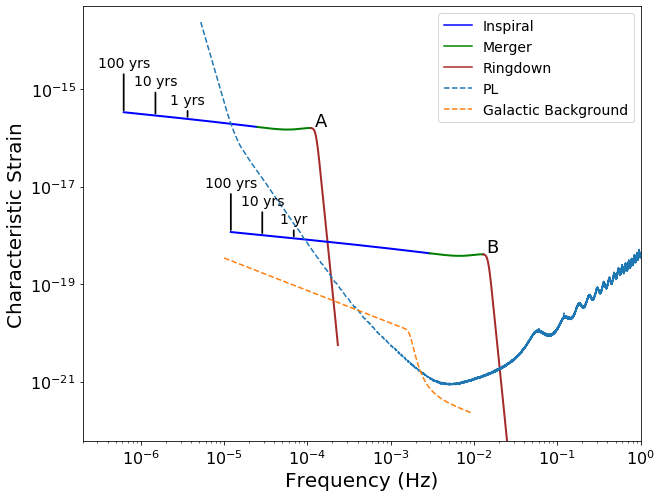

In [5]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,8)
phenomdwave = PhenomDWaveforms(num_points=4096)

q = 0.2
z = 1.0
s = 0.8
start_time = 100.0
end_time = 0.0
for M, z, letter in [[1e8, 0.75, 'A'], [5e5, 2.0, 'B']]:
    ax.set_ylim(6e-23, 5e-14)
    ax.set_xlim(1e-6, 1e-3)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(18)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(18)
    
    m1 = M/(1+q)
    m2 = M*q/(1+q)
    wave = phenomdwave(m1, m2, s, s, z, start_time, end_time)

    f = wave.freqs
    hc = wave.hc*np.sqrt(96/200) #averaging factor see Cornish and Robson 2018

    ins = np.where(f<wave.fmrg)[0]
    mrg = np.where((f>=wave.fmrg)&(f<=wave.fpeak))[0]
    rd = np.where(f>wave.fpeak)[0]

    ax.loglog(f[ins], hc[ins], color='blue', lw = 2)
    ax.loglog(f[mrg], hc[mrg], color='green', lw = 2)
    ax.loglog(f[rd], hc[rd], color='brown', lw = 2)
    
    ax.text(f[rd[0]]*1.1, hc[rd[0]]*1.1, letter, fontsize=18)

    N = m1*m2/(m1+m2)**2.
    start_times = np.array([100.0, 10.0,1.0])*ct.Julian_year/(1+z)

    tau = N*(start_times*ct.c)/(5.*(m1+m2)*Msun*ct.G/(ct.c**2.))
    flow = 1./(8.*ct.pi*(m1+m2)*Msun*ct.G/(ct.c**2.)*tau**(3./8.))*(1.+((11./32)*N+743./2688.)*tau**(-1./4.))*ct.c/(1+z)

    vert = [45, 30, 15]
    for i,(flow_i, st) in enumerate(zip(flow, start_times)):
        f_ind = np.where(f >= flow_i)[0][0]
        val = st*(1+z)/ct.Julian_year
        string = "%i yrs"%int(val) if val != 1.0 else "%i yr"%int(val)
        ax.annotate(string,xy=(f[f_ind], hc[f_ind]), xycoords='data',xytext=(0,vert[i]), ha='center', textcoords='offset points',arrowprops=dict(arrowstyle="-",linewidth = 1.75), fontsize=14)  

ax.plot(1,1, color='blue', ls='solid', label='Inspiral')
ax.plot(1,1, color='green', ls='solid', label='Merger')
ax.plot(1,1, color='brown', ls='solid', label='Ringdown')
for nc in ['PL', 'HB_wd_noise']:
    fn, hn = read_noise_curve(nc, noise_type_out='char_strain')
    if nc == 'HB_wd_noise':
        nc = 'Galactic Background'
    ax.loglog(fn, hn, label=nc, ls='dashed')
    
ax.tick_params(labelsize=16)
ax.set_xlabel('Frequency (Hz)', fontsize=20)
ax.set_ylabel(r'Characteristic Strain', fontsize=20)
ax.set_xlim(2e-7, 1e0)
ax.legend(prop={'size':14})
fig.savefig('figures/sensitivity_curves_and_signals.pdf', dpi=200)

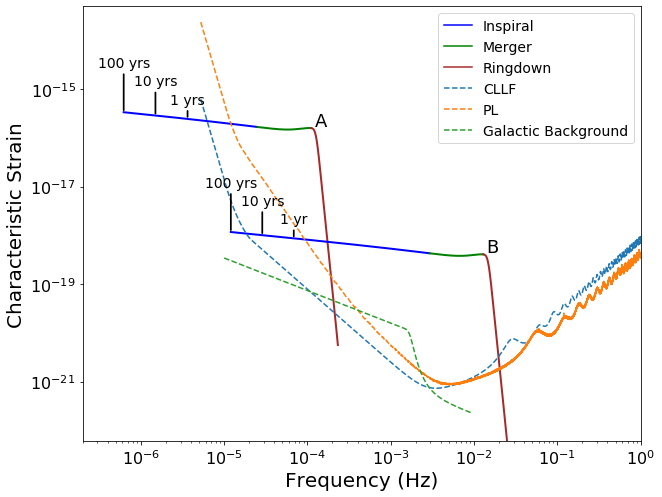

In [4]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,8)
phenomdwave = PhenomDWaveforms(num_points=4096)

q = 0.2
z = 1.0
s = 0.8
start_time = 100.0
end_time = 0.0
for M, z, letter in [[1e8, 0.75, 'A'], [5e5, 2.0, 'B']]:
    ax.set_ylim(6e-23, 5e-14)
    ax.set_xlim(1e-6, 1e-3)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(18)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(18)
    
    m1 = M/(1+q)
    m2 = M*q/(1+q)
    wave = phenomdwave(m1, m2, s, s, z, start_time, end_time)

    f = wave.freqs
    hc = wave.hc*np.sqrt(96/200) #averaging factor see Cornish and Robson 2018

    ins = np.where(f<wave.fmrg)[0]
    mrg = np.where((f>=wave.fmrg)&(f<=wave.fpeak))[0]
    rd = np.where(f>wave.fpeak)[0]

    ax.loglog(f[ins], hc[ins], color='blue', lw = 2)
    ax.loglog(f[mrg], hc[mrg], color='green', lw = 2)
    ax.loglog(f[rd], hc[rd], color='brown', lw = 2)
    
    ax.text(f[rd[0]]*1.1, hc[rd[0]]*1.1, letter, fontsize=18)

    N = m1*m2/(m1+m2)**2.
    start_times = np.array([100.0, 10.0,1.0])*ct.Julian_year/(1+z)

    tau = N*(start_times*ct.c)/(5.*(m1+m2)*Msun*ct.G/(ct.c**2.))
    flow = 1./(8.*ct.pi*(m1+m2)*Msun*ct.G/(ct.c**2.)*tau**(3./8.))*(1.+((11./32)*N+743./2688.)*tau**(-1./4.))*ct.c/(1+z)

    vert = [45, 30, 15]
    for i,(flow_i, st) in enumerate(zip(flow, start_times)):
        f_ind = np.where(f >= flow_i)[0][0]
        val = st*(1+z)/ct.Julian_year
        string = "%i yrs"%int(val) if val != 1.0 else "%i yr"%int(val)
        ax.annotate(string,xy=(f[f_ind], hc[f_ind]), xycoords='data',xytext=(0,vert[i]), ha='center', textcoords='offset points',arrowprops=dict(arrowstyle="-",linewidth = 1.75), fontsize=14)  

ax.plot(1,1, color='blue', ls='solid', label='Inspiral')
ax.plot(1,1, color='green', ls='solid', label='Merger')
ax.plot(1,1, color='brown', ls='solid', label='Ringdown')
for nc in ['CLLF', 'PL', 'HB_wd_noise']:
    fn, hn = read_noise_curve(nc, noise_type_out='char_strain')
    if nc == 'HB_wd_noise':
        nc = 'Galactic Background'
    ax.loglog(fn, hn, label=nc, ls='dashed')
    
ax.tick_params(labelsize=16)
ax.set_xlabel('Frequency (Hz)', fontsize=20)
ax.set_ylabel(r'Characteristic Strain', fontsize=20)
ax.set_xlim(2e-7, 1e0)
ax.legend(prop={'size':14})
fig.savefig('figures/sensitivity_curves_and_signals_2.pdf', dpi=200)

## Initial Histograms

In [ ]:
data = np.genfromtxt('simulation_input_data_lzk.txt', names=True)

m1 = data['mass_new_prev_in']
m2 = data['mass_new_prev_out']

separation = data['separation']*1e3

redshift = data['redshift']

total_mass = m1+m2

q = mass_ratio_func(m1, m2)

inds_set = []
for i in np.arange(1,5):
    inds_set.append(np.where((q<=10.0**-(i-1)) & (q>10.0**-(i)))[0])

inds_set.append(np.where((q<10.0**-(4)))[0])

total_num = len(total_mass)

fig, ax = plt.subplots(nrows=2, ncols=2)
ax = ax.ravel()
fig.set_size_inches(11,11)
xlims = [[-6,0],[5,10.6],[2.5,4],[-4.0,1.0]]
colors = ['blue', 'green', 'red', 'purple', 'goldenrod']

w = 0
for parameter in [q, total_mass, separation, redshift]:
    ww = 0
    for inds in inds_set:
        #weights = np.ones_like(parameter[inds])/float(len(parameter))
        #ax[w].hist(np.log10(parameter[inds]), bins=num_bins[w], histtype = 'step', weights=weights, log=True)

        bins = np.linspace(xlims[w][0], xlims[w][1], 25)
        try:
            ax[w].hist(np.log10(parameter[inds]), bins=bins, histtype = 'step', log=True, color = colors[ww])
        except IndexError:
            pdb.set_trace()
        ww+=1
        
    ax[w].set_ylim(9e-1, 1e4)
    ax[w].set_xlim(xlims[w])


    w+=1

#legend
legend_ind = 0
ax[legend_ind].plot([-100,-100], [-220, 200], color = colors[0], label = r'$10^{-1}<q\leq 10^0$')
ax[legend_ind].plot([-100,-100], [-220, 200], color = colors[1], label = r'$10^{-2}<q\leq 10^{-1}$')
ax[legend_ind].plot([-100,-100], [-220, 200], color = colors[2], label = r'$10^{-3}<q\leq 10^{-2}$')
ax[legend_ind].plot([-100,-100], [-220, 200], color = colors[3], label = r'$10^{-4}< q\leq 10^{-3}$')
ax[legend_ind].plot([-100,-100], [-220, 200], color = colors[4], label = r'$q\leq 10^{-4}$')

xtickfontsize = 16
xlabelfontsize = 18

#ax[0].legend(bbox_to_anchor=(3.0, 0.05), prop={'size':11})
legend = ax[0].legend(bbox_to_anchor=[0.05, 0.7],ncol=1, prop={'size':12}, fancybox=True, framealpha=1.0)
#legend = ax[1].legend(bbox_to_anchor=[1.2, 0.0], prop={'size':10.5}, ncol=1, fancybox=True, framealpha=1.0)
legend.get_frame().set_edgecolor('k')

#labels
ax[0].set_xlabel(r'Mass Ratio ($q$)', fontsize=xlabelfontsize)
ax0_xticks = [-6.0,-5.0, -4.0, -3.0, -2.0, -1.0, 0.0]
ax[0].set_xticks(ax0_xticks)
ax[0].set_xticklabels([r'$10^{%i}$'%int(i) for i in ax0_xticks], fontsize=xtickfontsize)

ax[1].set_xlabel(r'Total Mass ($M_\odot$)', fontsize=xlabelfontsize)
ax1_xticks = [5.0, 6.0,7.0, 8.0, 9.0, 10.0]
ax[1].set_xticks(ax1_xticks)
ax[1].set_xticklabels([r'$10^{%i}$'%int(i) for i in ax1_xticks], fontsize=xtickfontsize)

ax[2].set_xlabel('Initial Binary Separation (pc)', fontsize=xlabelfontsize)
ax2_xticks = [2.5, 3.0,3.5, 4.0]
ax[2].set_xticks(ax2_xticks)
ax[2].set_xticklabels([r'$10^{%1.2g}$'%i for i in ax2_xticks], fontsize=xtickfontsize)

ax[3].set_xlabel('Redshift z', fontsize=xlabelfontsize)
ax3_xticks = [-4.0, -3.0, -2.0, -1.0, 0.0, 1.0]
ax[3].set_xticks(ax3_xticks)
ax[3].set_xticklabels([r'$10^{%i}$'%int(i) for i in ax3_xticks], fontsize=xtickfontsize)

yticks = np.linspace(0.0,4.0, 5)

for w in range(4):
    ax[w].set_yticks(10**yticks)
    ax[w].set_yticklabels([r'$10^{%i}$'%int(i) for i in yticks], fontsize=16)

ax[0].set_ylabel('Count', fontsize=16)
ax[2].set_ylabel('Count', fontsize=16)
plt.subplots_adjust(left = 0.1, right=0.95, hspace=0.4, wspace = 0.3)
fig.savefig('figures/initial_parameter_hists.pdf', dpi = 200)

## Timescale Histograms

In [ ]:
fig, ax = plt.subplots(2,4, sharey=True, sharex=True)
ax = ax.ravel()
fig.set_size_inches(12, 8)

label_fontsize = 20
fig.text(0.02, 0.5, 'Count', rotation='vertical', va='center', ha='center', fontsize=label_fontsize)
fig.text(0.5, 0.02, 'Coalescence Timescale (yr)', va='center', ha='center', fontsize=label_fontsize)

plt.subplots_adjust(hspace=0.0, wspace=0.0)
mt_bins = np.arange(5, 9)
mr_bins = np.arange(-4, 0)

xticks = [8,9,10,11]
yticks = [0,1,2,3]
tick_fontsize = 14
for axis in ax:
    axis.set_xlim(7, 12)
    axis.set_ylim(0.9, 6e3)
    axis.set_xticks(xticks)
    axis.set_xticklabels([r'$10^{%i}$'%i for i in xticks], fontsize=tick_fontsize)
    axis.set_yticks([10**i for i in yticks])
    axis.set_yticklabels([r'$10^{%i}$'%i for i in yticks], fontsize=tick_fontsize)

labels = ['DA17','K17']

timescale_bins = np.linspace(7, 12, 30)

mt = evolve_out['data']['mt']
mr = evolve_out['data']['mr']
for i, exp in enumerate(mt_bins):
    keep = (mt>=10**exp) & (mt<10**(exp+1))
    
    for label in labels:
        ax[i].hist(np.log10(evolve_out[label]['timescale'][keep]), bins=timescale_bins, label=label, log=True, histtype='step')
    ax[i].text(0.3, 0.92, r'$10^{%i}<M<10^{%i}$'%(exp, exp+1),
                           ha="center", va="center", color="k", fontsize=12, transform=ax[i].transAxes, bbox=dict(facecolor='White'))

for i, exp in enumerate(mr_bins[::-1]):
    keep = (mr>=10.0**(exp-1)) & (mr<10.0**(exp))
    
    for label in labels:
        ax[len(mt_bins) + i].hist(np.log10(evolve_out[label]['timescale'][keep]), bins=timescale_bins, label=label, log=True, histtype='step')

    ax[len(mt_bins) + i].text(0.32, 0.92, r'$10^{%i}<q<10^{%i}$'%(exp, exp+1),
                                 ha="center", va="center", color="k", fontsize=12, transform=ax[len(mt_bins) + i].transAxes, bbox=dict(facecolor='White'))
    
ax[0].legend(loc='center left', bbox_to_anchor=[0.0, 0.75], prop={'size':11})
fig.savefig('figures/timescale_hists.pdf', dpi=200)

In [ ]:
data = np.genfromtxt('simulation_input_data_lzk.txt', names=True)
bins_mT = np.linspace(5.0, 10.5, 20)
bins_mr = np.linspace(-5.5, 0.0, 20)
bins_red = np.linspace(0.0, 7.5, 20)
bins, bins1 = np.meshgrid(bins_mT, bins_mr)
mr = data['mass_new_prev_in']/data['mass_new_prev_out']*(data['mass_new_prev_in']<=data['mass_new_prev_out']) + data['mass_new_prev_out']/data['mass_new_prev_in']*(data['mass_new_prev_in']>data['mass_new_prev_out'])
mT = data['mass_new_fin_out']
inds = np.where((data['mass_new_prev_in']>=1e6) & (data['mass_new_prev_out']>=1e6))

y_vals = [10**(-0.1), 10**3.8]
y_ticks = [1e0, 1e1, 1e2, 1e3]
y_ticks_labels = [r'$10^{%i}$'%np.log10(i) for i in y_ticks]
label_fontsize=20
tick_fontsize=18

fig, ax = plt.subplots(1,3)
fig.set_size_inches(16, 8)
ax = ax.ravel()
ax[0].hist(np.log10(mT), bins=bins_mT, log=True, color='green')
ax[0].hist(np.log10(mT[inds]), bins=bins_mT, log=True, color='dodgerblue')
ax[0].set_xlabel(r'Total Mass ($M_\odot$)', fontsize=label_fontsize)
xticks = [5, 6, 7, 8, 9, 10]
ax[0].set_xticks(xticks)
ax[0].set_xticklabels([r'$10^{%i}$'%i for i in xticks], fontsize=tick_fontsize)


ax[1].hist(np.log10(mr), bins=bins_mr, log=True, color='green', label='Advanced Extraction')
ax[1].hist(np.log10(mr[inds]), bins=bins_mr, log=True, color='dodgerblue', label=r'Require $m_1,m_2\geq10^6M_\odot$')
ax[1].set_xlabel(r'Mass Ratio ($q\leq1$)', fontsize=label_fontsize)
xticks = [-5, -4, -3, -2, -1, 0]
ax[1].set_xticks(xticks)
ax[1].set_xticklabels([r'$10^{%i}$'%i for i in xticks], fontsize=tick_fontsize)

ax[2].hist(data['redshift'], bins=bins_red, log=True, color='green')
ax[2].hist(data['redshift'][inds], bins=bins_red, log=True, color='dodgerblue')
ax[2].set_xlabel('Redshift z', fontsize=label_fontsize)
xticks = [0,2,4,6,8]
ax[2].set_xticks(xticks)
ax[2].set_xticklabels([r'$%i$'%i for i in xticks], fontsize=tick_fontsize)

for i in range(3):
    ax[i].set_ylim(y_vals)
    ax[i].set_yticks(y_ticks)
    ax[i].set_yticklabels(y_ticks_labels, fontsize=tick_fontsize)

ax[0].set_ylabel('Count', fontsize=label_fontsize)
ax[1].legend(prop={'size':14}, bbox_to_anchor=[0.96, 1.15])
fig.savefig('figures/extraction_difference.pdf', dpi=200)

In [ ]:
from matplotlib import cm
cmap = cm.gist_rainbow

cmap.set_bad('grey')
cmap.set_under('white')

dmt = 0.5
dmr = 0.5
mt_bins = np.arange(5, 11, dmt).astype(float)
mr_bins = np.arange(-5.5, 0.5, dmr).astype(float)

mt = evolve_out['data']['mt']
mr = evolve_out['data']['mr']

label_fontsize = 20
tick_fontsize = 16

labels = ['DA17', 'K17']

fig, ax = plt.subplots(1, len(labels), sharex=True, sharey=True)
fig.set_size_inches(18,8)
plt.subplots_adjust(wspace=0.05)
cax = fig.add_axes([0.9,0.2,0.02,0.6])
plt.subplots_adjust(bottom=0.0, top=1.0, right=0.85)
try:
    ax = ax.ravel()
except AttributeError:
    ax = [ax]

binned_coal_frac = np.zeros((len(mt_bins)-1, len(mr_bins)-1))
binned_life_mean = np.zeros_like(binned_coal_frac)
check_mr = np.zeros_like(binned_coal_frac)
check_mt = np.zeros_like(binned_coal_frac)
keep_vals = np.zeros_like(binned_coal_frac, dtype=int)

for num, label in enumerate(labels):
    inds = []
    keep_val_total = 0
    t_coal = evolve_out[label]['timescale']
    coal_bool = evolve_out[label]['coalesced']
    for i,mt_exp in enumerate(mt_bins[:-1]):
        for j,mr_exp in enumerate(mr_bins[1:]):
            keep = ((mt>10**mt_exp) & (mt<10**(mt_exp+dmt)) & (mr>10**(mr_exp-dmr)) & (mr<10**mr_exp))
            inds.append(np.where(keep)[0])
            if np.sum(keep) == 0:
                binned_coal_frac[i][j] = -1.0
                binned_life_mean[i][j] = -1.0
                keep_vals[i][j] = 0
            
            else:
                binned_coal_frac[i][j] = np.sum(coal_bool[keep])/len(coal_bool[keep])
                #print(binned_coal_frac[i][j], i, j)
                binned_life_mean[i][j] = np.mean(np.log10(t_coal[keep]))
                keep_vals[i][j] = np.sum(keep)
                
            check_mr[i][j] = 10**mr_exp
            check_mt[i][j] = 10**mt_exp
    
    binned_coal_frac = np.ma.masked_where(binned_coal_frac == 0.0, binned_coal_frac)
    im = ax[num].imshow(binned_coal_frac, cmap=cmap, vmin=0.0, vmax=1.0)
    
    ax[num].set_xticks(np.arange(-1, len(mr_bins),2)+1.5)
    ax[num].set_xticklabels([r'$10^{%i}$'%i for i in np.arange(-5,1)], fontsize=tick_fontsize)
    ax[num].set_yticks(np.arange(0, len(mt_bins), 2)-0.5)
    ax[num].set_yticklabels([r'$10^{%i}$'%i for i in np.arange(5,11)], fontsize=tick_fontsize)
    ax[num].set_xlim(-0.5, len(mr_bins)-1.5)
    ax[num].set_ylim(-0.5, len(mt_bins)-1.5)
    #ax[num].grid(color='black')
    
    ax[num].set_xlabel(r'Mass Ratio', fontsize=label_fontsize)
    if num == 0:
        ax[num].set_ylabel(r'Total Mass ($M_\odot$)', fontsize=label_fontsize)

    for i in range(len(mt_bins)-1):
        for j in range(len(mr_bins)-1):
            if keep_vals[i, j] == 0:
                continue
            ax[num].text(j, i, '%i'%keep_vals[i, j],
                           ha="center", va="center", color="k", fontsize=10)
            keep_val_total += keep_vals[i, j]
     
    ax[num].text(-0.3,0.05, label, ha="left", va="center", color="white", fontsize=20,
                 bbox=dict(facecolor='black', edgecolor='black', pad=5.0))
        
cax = fig.colorbar(im, cax=cax)
cax.set_label('Coalescence Fraction', fontsize=20, labelpad=20)
cax.set_ticks([0,0.2,0.4,0.6,0.8,1])
cax.ax.tick_params(labelsize=16)
#fig.savefig('figures/coalescence_fractions.pdf', dpi=200)

In [ ]:
labels = ['DA17','K17', 'ND-old', 'ND']
fig, ax = plt.subplots(1,4, sharey=True)
plt.subplots_adjust(wspace=0.1)
fig.set_size_inches(14,8)
ax = ax.ravel()

for i, label in enumerate(labels):
    for key1 in ['PL', 'CLLF']:
        for key2 in ['ins', 'mrg_rd', 'spec']:
            if key1 == 'CLLF' and key2 == 'spec':
                legend=True
            else:
                legend=False
            ax[i] = merger_integrand(evolve_out_base, [label], ax[i], key1 + '_' + key2, label_fontsize=22, tick_fontsize=18,
                                     legend=legend, legend_label='key')
    ax[i].set_ylim(0.0, 0.44)
    if i > 0:
        ax[i].set_ylabel('')
    ax[i].set_title(label, fontsize=18)
#fig.savefig('figures/detection_results.pdf', dpi=200)

In [ ]:
num_events_ins = {}
num_events_all = {}
labels = ['DA17','K17', 'ND-old', 'ND']
fig, ax = plt.subplots(1, 4, sharey=True, sharex=True)
ax = ax.ravel()
fig.set_size_inches(16, 6)
bins = np.linspace(-2, 2, 30)
for i, label in enumerate(labels):
    for key1 in ['PL', 'CLLF']:
        ax[i].hist(np.log10(evolve_out[label]['cats_det'][key1]['t_event']), bins=bins,
                   log=True, density=True, histtype='step', label=key1, lw=2)
        num_events_ins[label + '_' + key1] = len(np.where(evolve_out[label]['cats_det'][key1]['t_event'] > t_obs)[0])
        num_events_all[label + '_' + key1] = len(evolve_out[label]['cats_det'][key1]['t_event'])
        
    ax[i].set_ylim(8e-4,)
    ax[i].set_xticks([-2, -1, 0, 1, 2])
    ax[i].set_xticklabels([r'$10^{%i}$'%i for i in [-2, -1, 0, 1, 2]])
    ax[i].tick_params(labelsize=18)
    ax[i].axvline(np.log10(t_obs), ls='dashed', color='k', lw=2)
    ax[i].set_title(label, fontsize=18)
ax[0].set_ylabel('PDF', fontsize=18)
fig.text(0.5, 0.02, 'Time to Merger at Start of Mission (yrs)', fontsize=18, ha='center')
ax[0].legend(loc='upper left', prop={'size': 13})
fig.savefig('figures/time_to_merger.pdf')

In [ ]:
for key in num_events: 
    inspiral_events = num_events_ins[key]/num_catalogs/t_obs
    all_events = num_events_all[key]/num_catalogs/t_obs
    print(key, inspiral_events, all_events, inspiral_events/all_events)

In [ ]:
t_obs

In [ ]:
fig, ax = plt.subplots(1, 4, sharex=True, sharey=True)
ax = ax.ravel()
fig.set_size_inches(14, 6)
plt.subplots_adjust(wspace=0.15, bottom=0.17)

for i, (label, file_label) in enumerate(zip(['ND', 'ND-6', 'DA17', 'K17'],['ND', 'ND-old', 'FDFA', 'LZK'])):
    data = np.genfromtxt(file_label + '_out.txt', names=True)
    if label == 'ND-old':
        label = 'ND-6'
    x = data['st']
    for key in ['PL', 'CLLF']:
        y = data[key + '_rate']
        ax[i].loglog(x, y, label=key)
        
    ax[i].set_title(label, fontsize=20)
    ax[i].tick_params(axis='both', which='major', labelsize=18)

    ax[i].set_ylim(2e-5, 2)
    ax[i].axvline(5.0, lw=2, ls='dashed', color='k')
ax[0].set_ylabel(r'Detection Rate (yr$^{-1}$)', fontsize=20)
ax[0].legend(loc='upper right', prop={'size':12})
ax[0].set_xlim(1.0,)
fig.text(0.5, 0.04, 'Time Before Merger at Start of Observation (yrs)', ha='center', fontsize=20)
fig.savefig('figures/merger_rate_over_time.pdf', dpi=200)

In [ ]:
### we run the code below in a separate python script and save to files

data = np.genfromtxt('simulation_input_data_lzk.txt', names=True)

evolve_dict = {'fname': 'simulation_input_data_lzk.txt'}
evolution_classes = [[EvolveLZK, 'K17'],
                     [evolveFDFA, 'DA17'],
                     #[ConstantTime, 'Constant'],
                     [NoDelay, 'ND'],
                     [NoDelayOrigExtract, 'ND-old']]

start_time = np.logspace(0, 2, 100)
t_obs = 5.0
end_time = (start_time - t_obs)*(start_time > t_obs)
dz = 0.001
evolve_out = {}
for evolve_class, label in evolution_classes:
    evolve = evolve_class(**evolve_dict)
    evolve.evolve()
    keep = (evolve.coalescence_time<cosmo.age(0.0).value*1e9) & (mass_ratio_func(data['mass_new_prev_in'], data['mass_new_prev_out'])>1e-4)
    z_coal = z_at(evolve.coalescence_time[keep])
    
    merger_rate_info = {}
    mr = MergerRate(z_coal, 106.5**3,dz=dz)
    print(len(z_coal))
    zs, integrand, rate = mr.merger_rate(return_for_plot=True)
    merger_rate_info['non_det'] = {'rate': rate}
    
    for st, et in zip(start_time, end_time):
        snr_vals = (snr(evolve.m1[keep], evolve.m2[keep], np.full(len(evolve.m1[keep],), 0.8),
                        np.full(len(evolve.m1[keep],), 0.8), z_coal, st, et,
                        sensitivity_curves=['PL', 'CLLF'], add_wd_noise='True', signal_type=['all', 'ins', 'mrg', 'rd']))
        #pdb.set_trace()

        for key in ['PL', 'CLLF']:
            key2 = 'all'
            mr_det = MergerRate(z_coal[snr_vals[key + '_wd_' + key2]>8.0], 106.5**3,dz=dz)
            zs_det, integrand_det, rate_det = mr_det.merger_rate(return_for_plot=True)
            merger_rate_info[key + '_' + str(st)] = {'rate': rate_det}
    
        print(label, st, 'done')
        #pdb.set_trace()
    
    
    evolve_out[label] = {'merger_rate_info': merger_rate_info,
                         'coalesced': keep, 'timescale': evolve.t_delay}
    print(label, 'done')
#evolve_out['data'] = {'m1': data['mass_new_prev_in'], 'm2': data['mass_new_prev_out'],
#                          'mt': data['mass_new_prev_in'] + data['mass_new_prev_out'],
#                          'mr': mass_ratio_func(data['mass_new_prev_in'], data['mass_new_prev_out'])}

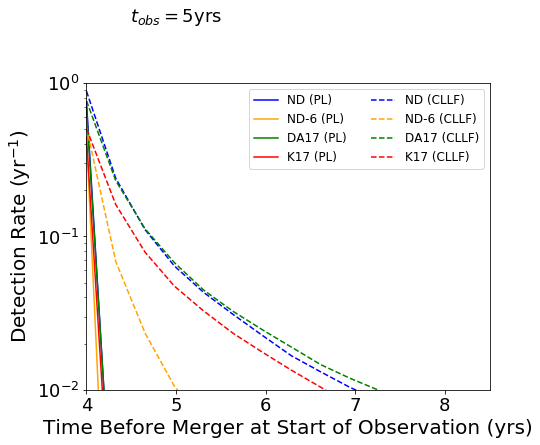

In [15]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
ax = [ax]
fig.set_size_inches(8, 6)
plt.subplots_adjust(wspace=0.15, bottom=0.17, left=0.2)
label_keys = {'ND': 'ND', 'ND-6':'ND-old', 'DA17': 'FDFA', 'K17': 'LZK'}
for key, ls in [['PL', 'solid'], ['CLLF', 'dashed']]:
    for i, (label, color) in enumerate([['ND', 'blue'], ['ND-6', 'orange'], ['DA17', 'green'], ['K17', 'red']]):
        i = 0
        data = np.genfromtxt(label_keys[label] + '_out.txt', names=True)
        x = data['st']

        y = data[key + '_rate']
        ax[i].semilogy(x, y, label=label + ' (' + key + ')', lw=1.5, ls=ls, color=color)

        #ax[i].set_title(label, fontsize=20)
        ax[i].tick_params(axis='both', which='major', labelsize=18)

ax[0].set_ylim(1e-2, 1)
ax[0].set_xlim(4.0, 8.5)
ax[0].set_xticks([4, 5, 6, 7, 8])
#ax[0].axvline(5.0, lw=3, ls='dashed', color='k')
ax[0].set_ylabel(r'Detection Rate (yr$^{-1}$)', fontsize=20)
ax[0].legend(loc='upper right', prop={'size':12}, ncol=2)
ax[0].text(5.0, 2.5, r'$t_{obs}=5$yrs', fontsize=18, ha='center')
ax[0].set_xlabel('Time Before Merger at Start of Observation (yrs)', ha='center', fontsize=20)
fig.savefig('figures/merger_rate_over_time_new.pdf', dpi=200)

In [24]:
labels = ['ND', 'ND-6', 'DA17', 'K17']
scs = ['PL', 'CLLF']
t_obs = 4.0
num_cats = 10000
for label in labels:
    for sc in scs:
        output = evolve_out[label]['cats_det'][sc]
        num_det_all = len(output)/(t_obs*num_cats)
        ins_only = np.where((output['snr_ins']>=8.0) & (output['snr_mr']<8.0))[0]
        num_det_ins = len(ins_only)/(t_obs*num_cats)
        print('Evolve:', label, 'sc:', sc, 'all:', num_det_all, 'ins:', num_det_ins, 'percent: %.3g:'%(float(num_det_ins)/float(num_det_all)))

Evolve: ND sc: PL all: 0.793025 ins: 0.00425 percent: 0.00536:
Evolve: ND sc: CLLF all: 1.083975 ins: 0.1885 percent: 0.174:
Evolve: ND-6 sc: PL all: 0.466975 ins: 0.00145 percent: 0.00311:
Evolve: ND-6 sc: CLLF all: 0.5662 ins: 0.046725 percent: 0.0825:
Evolve: DA17 sc: PL all: 0.71565 ins: 0.004575 percent: 0.00639:
Evolve: DA17 sc: CLLF all: 0.967975 ins: 0.195625 percent: 0.202:
Evolve: K17 sc: PL all: 0.465825 ins: 0.0034 percent: 0.0073:
Evolve: K17 sc: CLLF all: 0.639575 ins: 0.1265 percent: 0.198:


In [ ]:
evolve_out[label]['cats_det'][sc]

In [ ]:
uni, uni_count = np.unique(evolve_out['ND']['cats_det']['CLLF']['cat'], return_counts=True)

In [ ]:
np.where(evolve_out['ND']['cats_det']['CLLF']['cat'] == 0)